## Initialization

In [ ]:
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
from sklearn.cluster import KMeans
from skimage import color

In [ ]:
DEPTH_PATH = Path("/content/drive/MyDrive/dh/book_covers/covers/depth/")
IMAGE_PATH = Path("/content/drive/MyDrive/dh/book_covers/covers/")
DEPTH_PATHS = list(DEPTH_PATH.glob("*.png"))
IMAGE_PATHS = list(IMAGE_PATH.glob("*.png"))

In [ ]:
CSV_FILE_PATH = Path("/content/drive/MyDrive/dh/book_covers/final_books.csv")
df = pd.read_csv(CSV_FILE_PATH)

## Depth Estimation


In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [ ]:
from transformers import pipeline
import torch
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend()
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


In [ ]:
from PIL import Image
from pathlib import Path
from tqdm import tqdm

cover_path = Path("/content/drive/MyDrive/dh/book_covers/covers/")

image_paths = list(cover_path.glob("*.png"))

for image_path in tqdm(image_paths):
  depth_image_path = Path(cover_path, "depth", image_path.name)
  if depth_image_path.exists():
    continue
  image = Image.open(image_path)
  predictions = pipe(image)
  depth_image = predictions["depth"]
  depth_image.save(depth_image_path)


 97%|█████████▋| 3773/3898 [08:05<00:12, 10.00it/s]

## dxy-Distribution

In [ ]:
depth_by_height_list = np.empty((len(DEPTH_PATHS), 100))
depth_by_width_list = np.empty((len(DEPTH_PATHS), 100))

for image_path in tqdm(DEPTH_PATHS):
  index = int(image_path.stem) - 1
  image = Image.open(image_path)
  image = image.resize((100, 100))
  image = np.array(image)

  depth_by_height = np.mean(image, axis=1)
  depth_by_height_list[index, :] = depth_by_height

  depth_by_width = np.mean(image, axis=0)
  depth_by_width_list[index, :] = depth_by_width


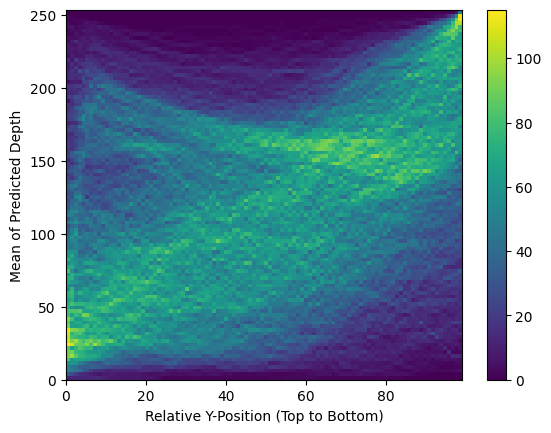

In [ ]:
data = np.transpose(depth_by_height_list)

_ = plt.hist2d(np.repeat(range(data.shape[0]), data.shape[1]),
           data.flatten(),
           bins=100,
           cmap='viridis')
_ = plt.xlabel('Relative Y-Position (Top to Bottom)')
_ = plt.ylabel('Mean of Predicted Depth')
_ = plt.colorbar()

In [ ]:
selection = np.where(depth_by_height_list[:, 15] > 175)[0]

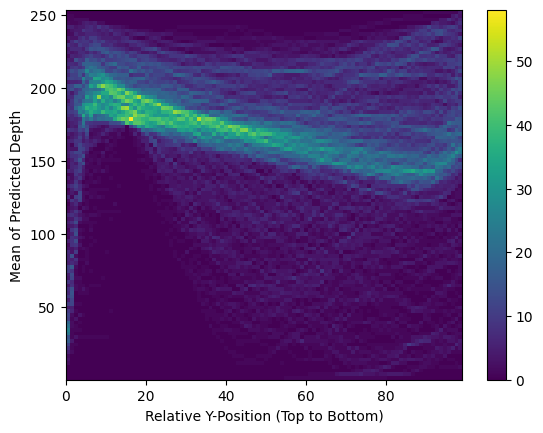

In [ ]:
data = np.transpose(depth_by_height_list[selection])

_ = plt.hist2d(np.repeat(range(data.shape[0]), data.shape[1]),
           data.flatten(),
           bins=100,
           cmap='viridis')
_ = plt.xlabel('Relative Y-Position (Top to Bottom)')
_ = plt.ylabel('Mean of Predicted Depth')
_ = plt.colorbar()

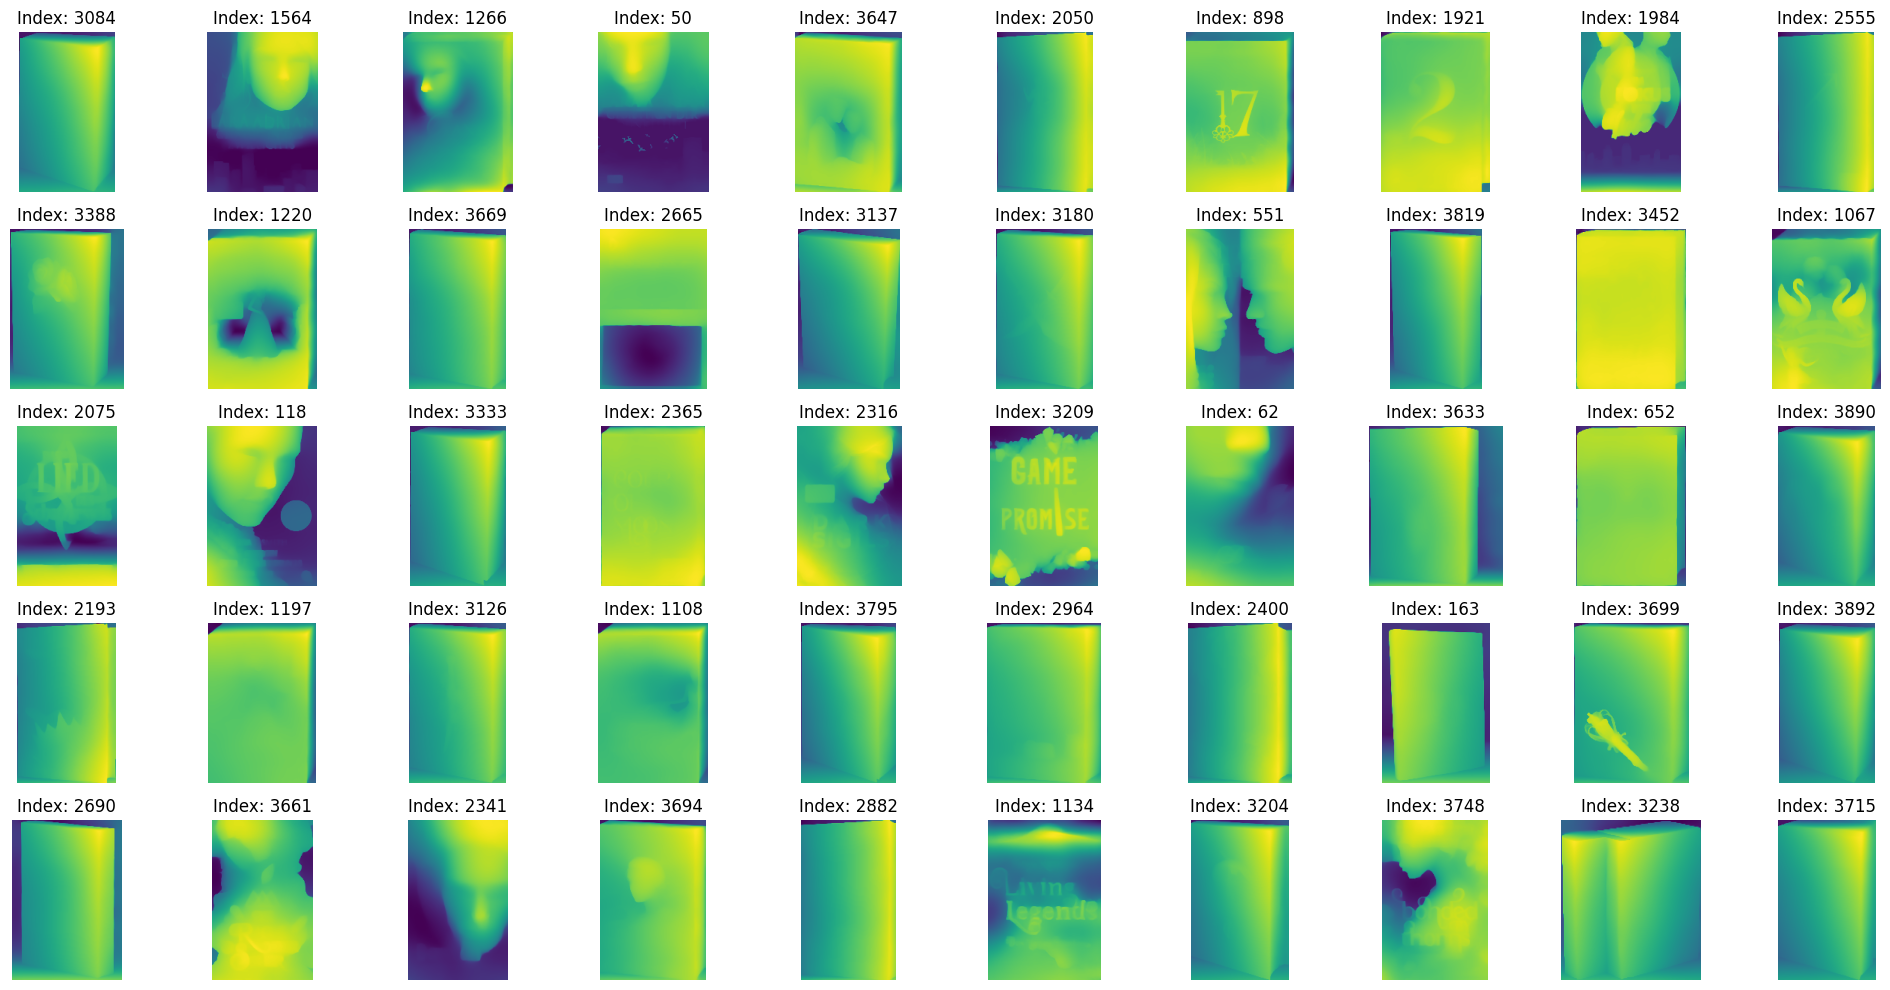

In [ ]:
random_indices = np.random.choice(selection, 50)

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.ravel()

for i, index in enumerate(random_indices):
    image_path = Path(DEPTH_PATH, f"{index+1}.png")
    image = Image.open(image_path)

    axes[i].imshow(image)
    axes[i].set_title(f"Index: {index}")
    axes[i].axis('off')

for i in range(len(random_indices), 50):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

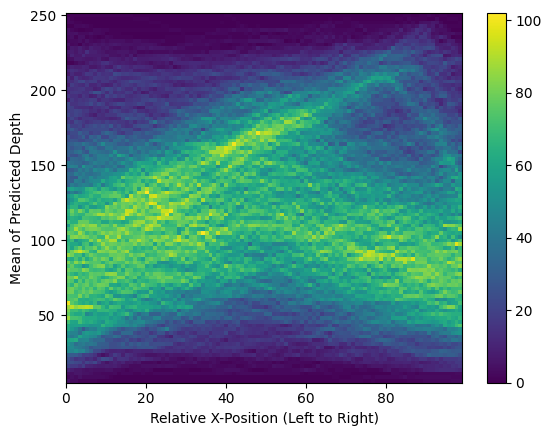

In [ ]:
data = np.transpose(depth_by_width_list)

_ = plt.hist2d(np.repeat(range(data.shape[0]), data.shape[1]),
           data.flatten(),
           bins=100,
           cmap='viridis')
_ = plt.xlabel('Relative X-Position (Left to Right)')
_ = plt.ylabel('Mean of Predicted Depth')
_ = plt.colorbar()

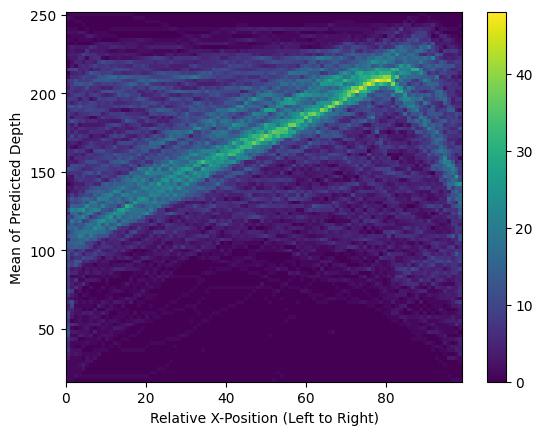

In [ ]:
data = np.transpose(depth_by_width_list[selection])

_ = plt.hist2d(np.repeat(range(data.shape[0]), data.shape[1]),
           data.flatten(),
           bins=100,
           cmap='viridis')
_ = plt.xlabel('Relative X-Position (Left to Right)')
_ = plt.ylabel('Mean of Predicted Depth')
_ = plt.colorbar()

# Over Time

In [ ]:
book_years = np.empty(df.shape[0])
depth_by_height_list = np.empty((df.shape[0], 100))
depth_by_width_list = np.empty((df.shape[0], 100))

for i in tqdm(range(df.shape[0])):
  index = df['ID'].iloc[i]
  image_path = Path(DEPTH_PATH, f"{index}.png")
  image = Image.open(image_path)
  image = image.resize((100, 100))
  image = np.array(image)

  depth_by_height = np.mean(image, axis=1)
  depth_by_height_list[index-1, :] = depth_by_height

  depth_by_width = np.mean(image, axis=0)
  depth_by_width_list[index-1, :] = depth_by_width

  book_years[index-1] = date.fromisoformat(df['Release Date'].iloc[index-1]).year


In [ ]:
np.save("/content/drive/MyDrive/dh/book_covers/book_years.npy", book_years)
np.save("/content/drive/MyDrive/dh/book_covers/depth_by_height_list.npy", depth_by_height_list)
np.save("/content/drive/MyDrive/dh/book_covers/depth_by_width_list.npy", depth_by_width_list)

In [ ]:
book_years = np.load("/content/drive/MyDrive/dh/book_covers/book_years.npy")
depth_by_height_list = np.load("/content/drive/MyDrive/dh/book_covers/depth_by_height_list.npy")
depth_by_width_list = np.load("/content/drive/MyDrive/dh/book_covers/depth_by_width_list.npy")

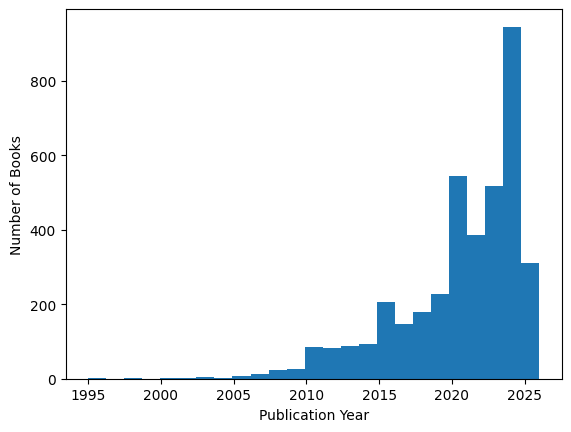

In [ ]:
_ = plt.hist(book_years, bins=25)
_ = plt.xlabel('Publication Year')
_ = plt.ylabel('Number of Books')

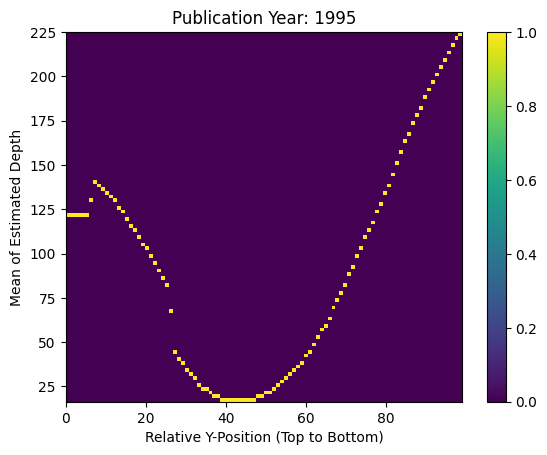

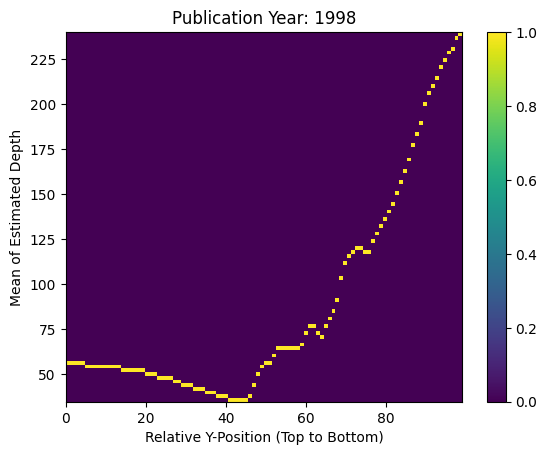

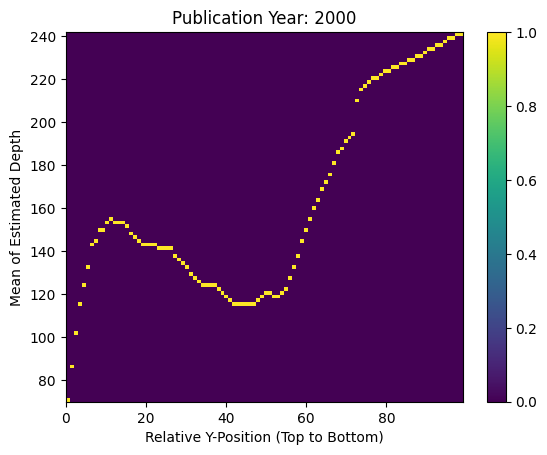

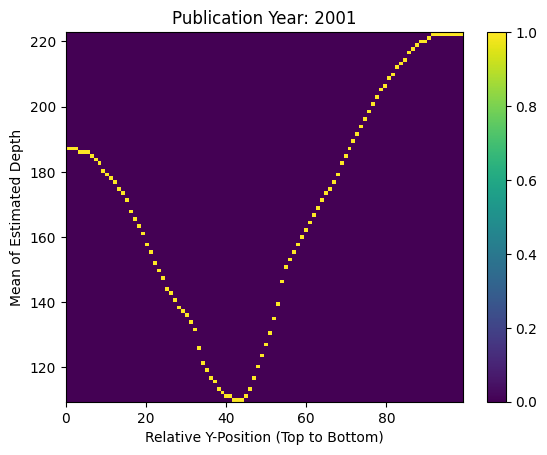

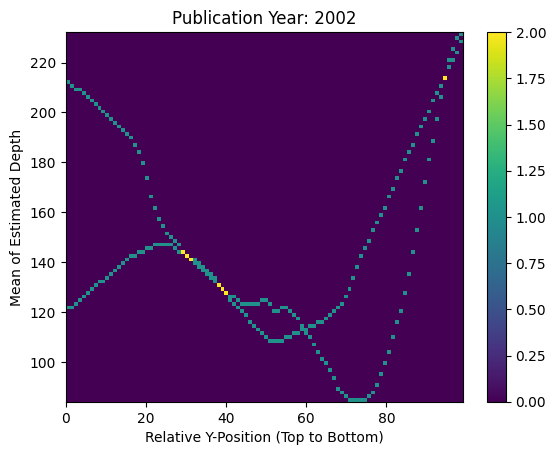

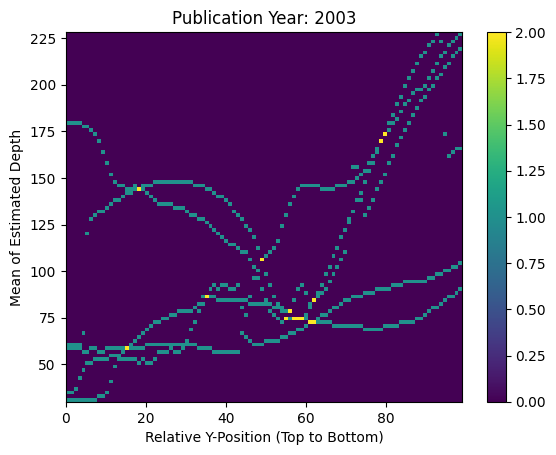

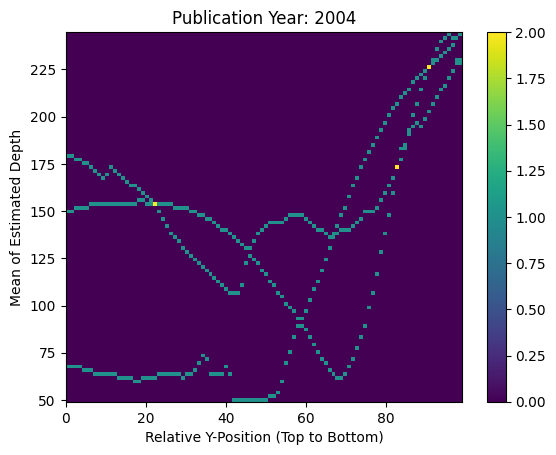

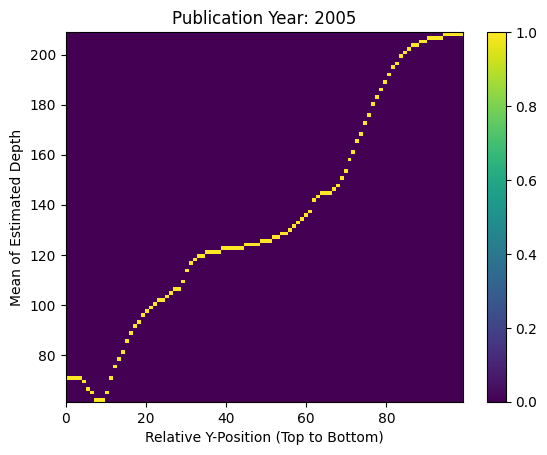

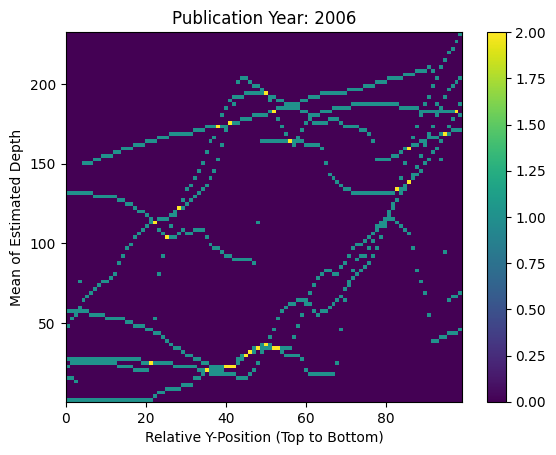

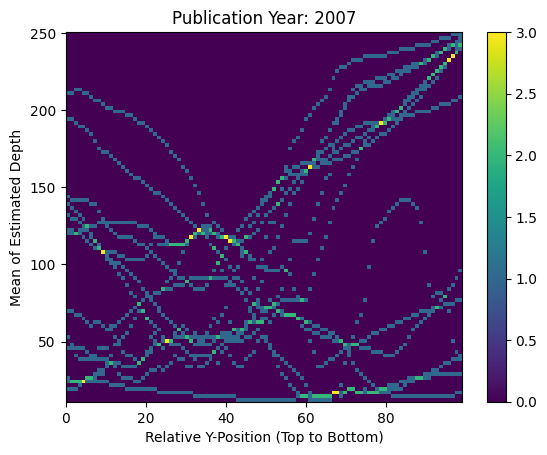

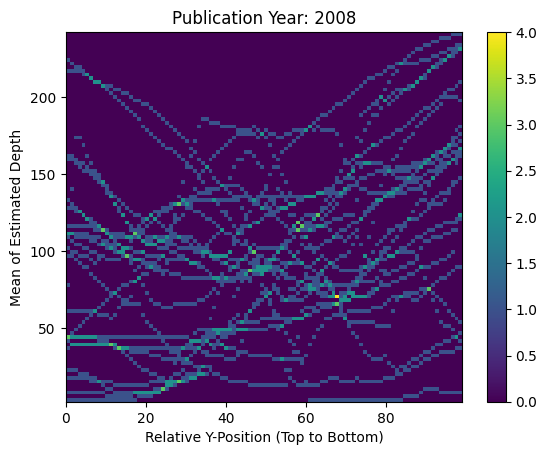

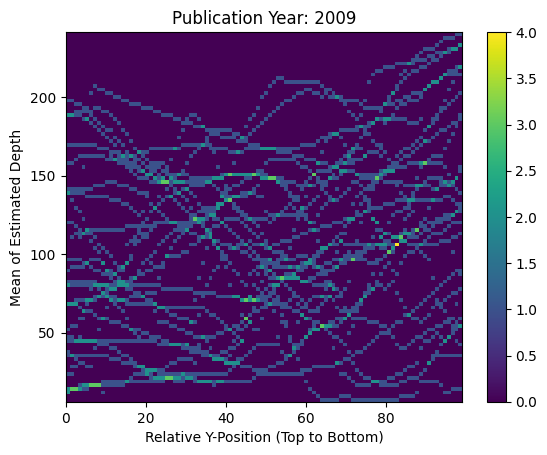

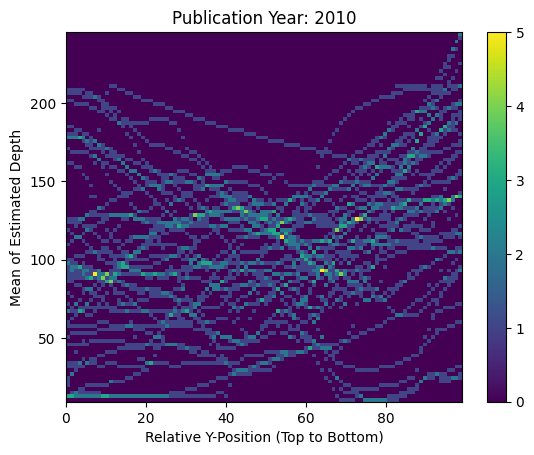

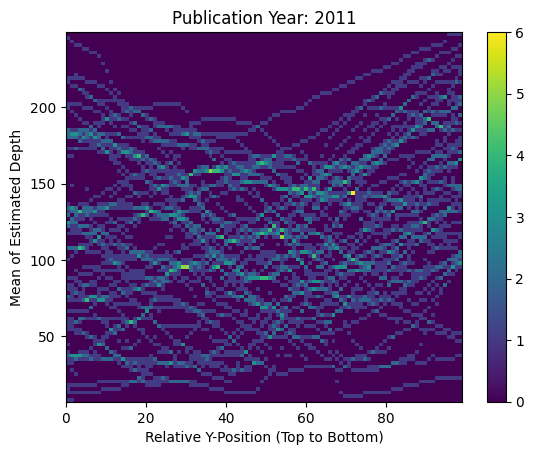

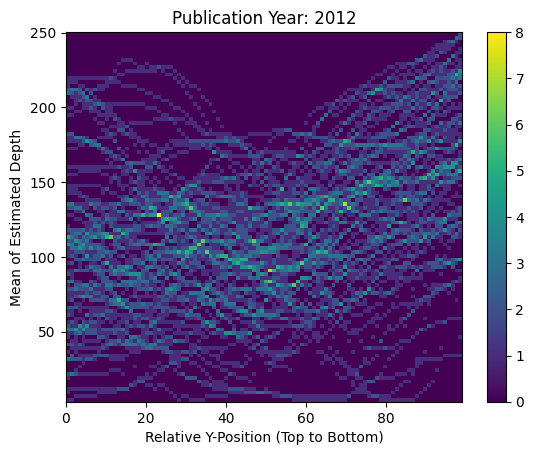

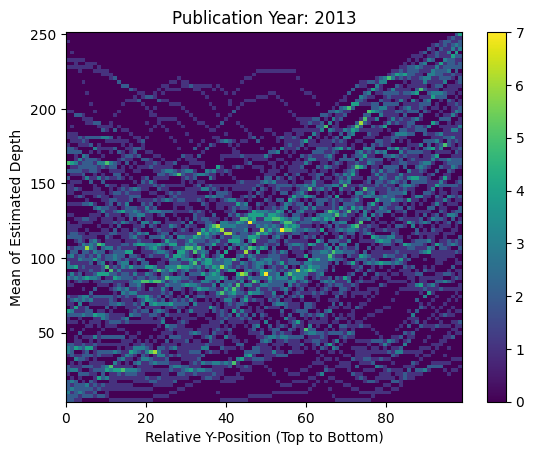

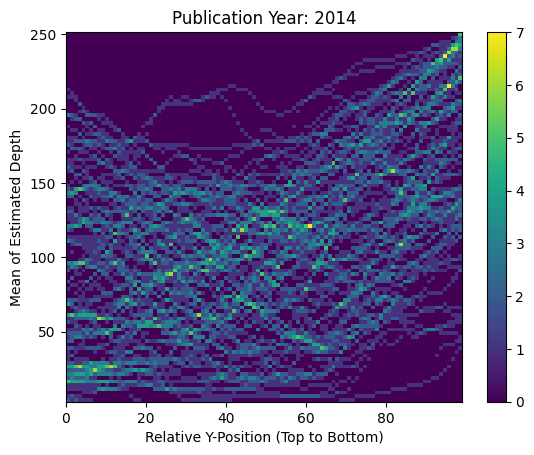

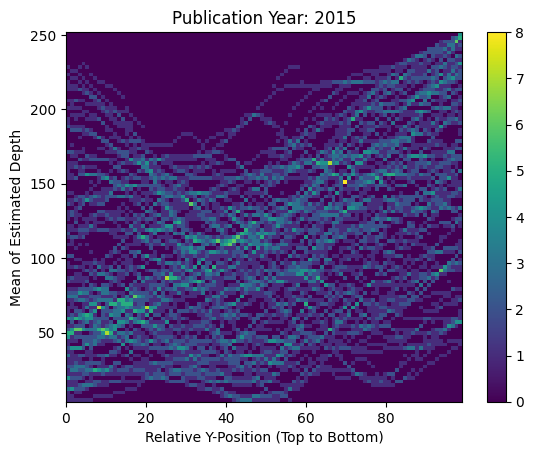

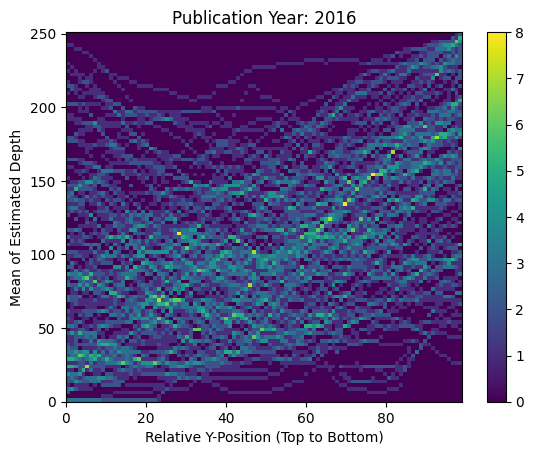

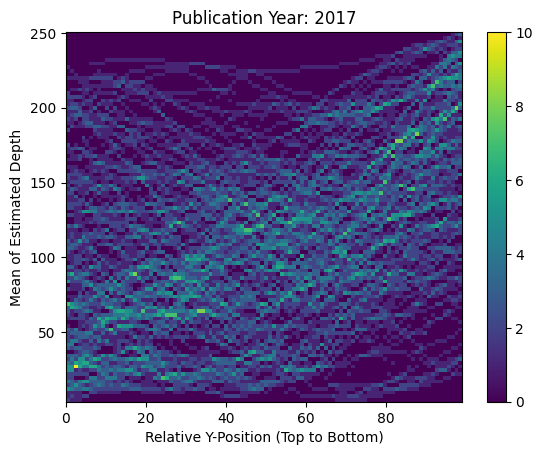

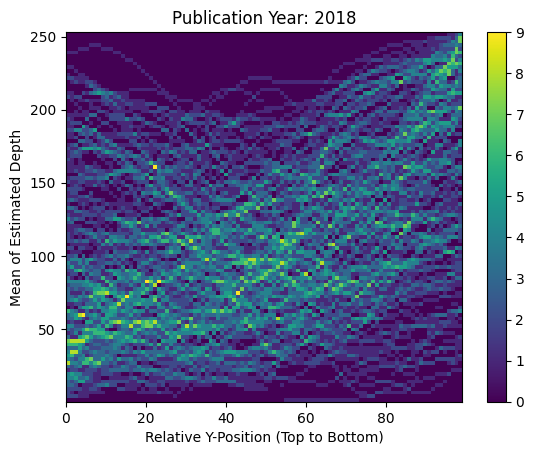

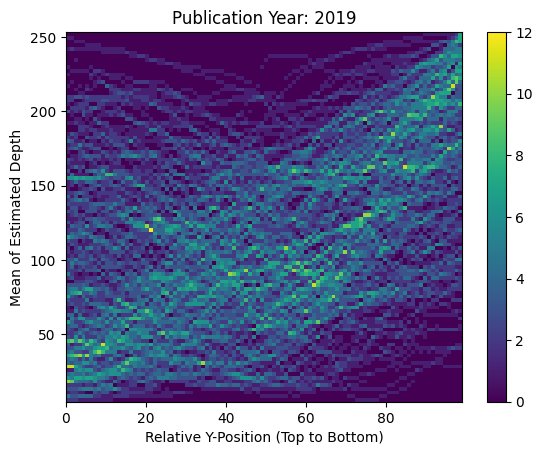

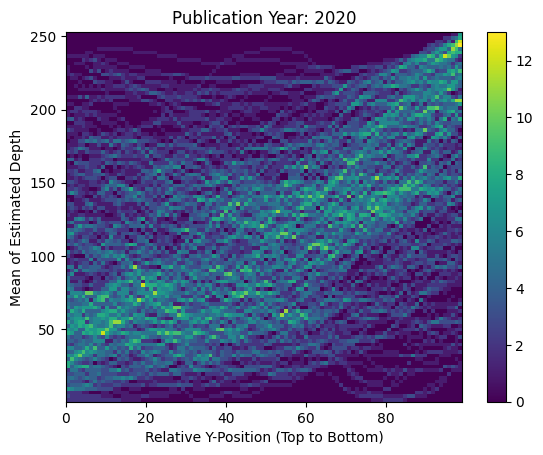

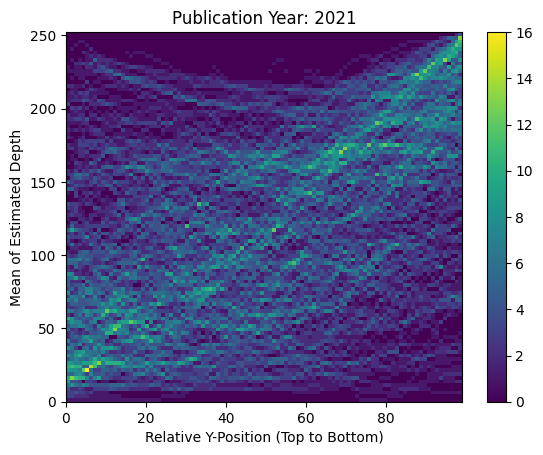

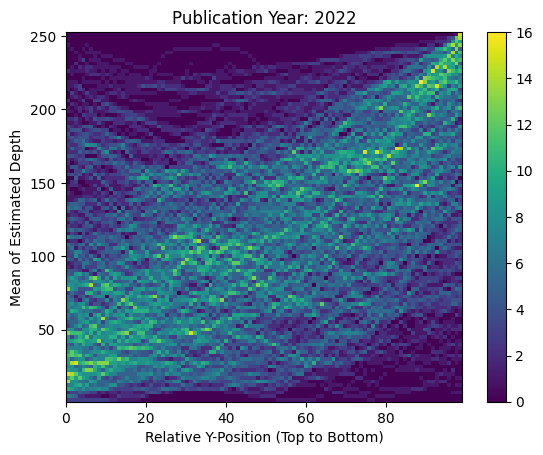

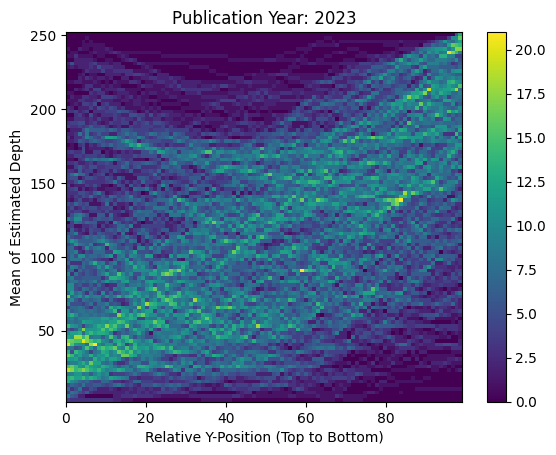

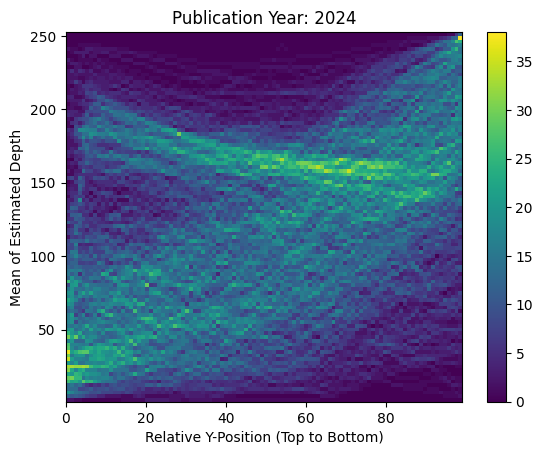

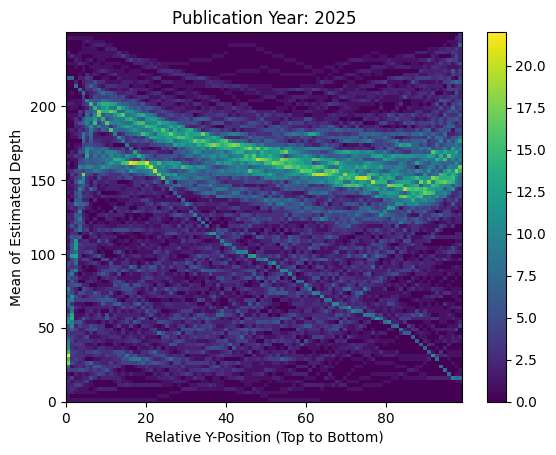

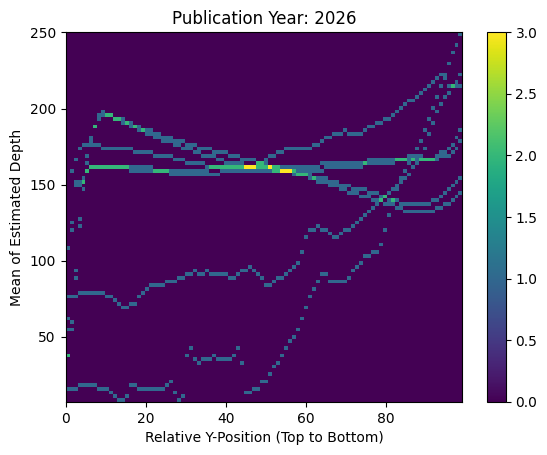

In [ ]:
for year in np.unique(book_years):
    data = np.transpose(depth_by_height_list[book_years == year])
    plt.figure()
    _ = plt.hist2d(np.repeat(range(data.shape[0]), data.shape[1]),
                data.flatten(),
                bins=100,
                #vmax=25,
                cmap='viridis')
    _ = plt.xlabel('Relative Y-Position (Top to Bottom)')
    _ = plt.ylabel('Mean of Estimated Depth')
    _ = plt.title(f'Publication Year: {int(year)}')
    _ = plt.colorbar()
    plt.show()

# Fore-, Middle- and Backround

In [ ]:
depth_kmeans = KMeans(n_clusters=3, random_state=42)

for i in tqdm(range(df.shape[0])):
  index = df['ID'].iloc[i]
  image_path = Path(DEPTH_PATH, f"{index}.png")
  image = Image.open(image_path)
  image = np.array(image)

  depth = image.flatten().reshape(-1,1)
  depth_kmeans.fit(depth)

  labels = depth_kmeans.labels_
  dominant_color_cluster_colors = depth_kmeans.cluster_centers_
  sorted_indices = np.argsort(dominant_color_cluster_colors.flatten())
  sorted_labels = np.empty(labels.shape, dtype=np.uint8)
  sorted_labels[labels == sorted_indices[0]] = 0
  sorted_labels[labels == sorted_indices[1]] = 128
  sorted_labels[labels == sorted_indices[2]] = 255

  fmb_image = (sorted_labels.reshape(image.shape)).astype(np.uint8)
  fmb_image = Image.fromarray(fmb_image)
  fmb_image.save(Path(DEPTH_PATH, "fmb", f"{index}.png"))


In [ ]:
book_years = np.load("/content/drive/MyDrive/dh/book_covers/book_years.npy")
fmb_by_year = np.zeros((2026-1995+1, 3), np.uint64)

for i in tqdm(range(df.shape[0])):
  index = df['ID'].iloc[i]
  year = book_years[index-1]
  fmb_image = np.round(np.array(Image.open(Path(DEPTH_PATH, "fmb", f"{index}.png"))) / 128).astype(np.uint32)
  fmb_counts = np.unique(fmb_image.flatten(), return_counts=True)
  fmb_by_year[int(year-1995), fmb_counts[0]] += fmb_counts[1].astype(np.uint64)


100%|██████████| 3898/3898 [00:20<00:00, 192.33it/s]


In [ ]:
np.save("/content/drive/MyDrive/dh/book_covers/fmb_by_year.npy", fmb_by_year)

In [ ]:
fmb_by_year = np.load("/content/drive/MyDrive/dh/book_covers/fmb_by_year.npy")

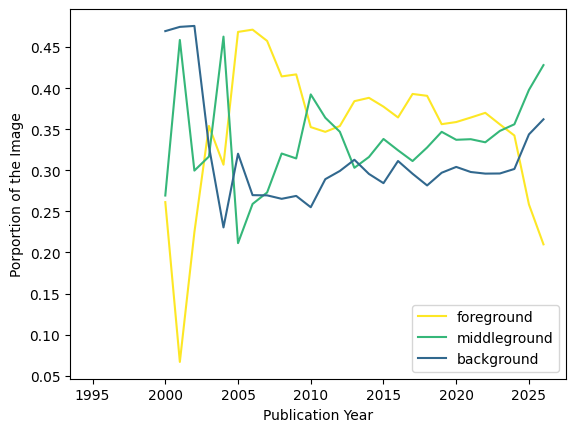

In [ ]:
fig, ax = plt.subplots()

for i in range(fmb_by_year.shape[1]):
   ax.plot(np.arange(len(fmb_by_year_normalized[:, i])) + 1995,
           fmb_by_year_normalized[:, i],
           label=fmb_names[i],
           color=plt.cm.viridis(1-i/fmb_by_year.shape[1]),
           )

ax.set_xlabel("Publication Year")
ax.set_ylabel("Porportion of the Image")
_=ax.legend()

<ipython-input-63-44f7f69aca93>:5: RuntimeWarning: invalid value encountered in divide
  fmb_by_year_normalized = fmb_by_year / fmb_by_year.sum(axis=1, keepdims=True)


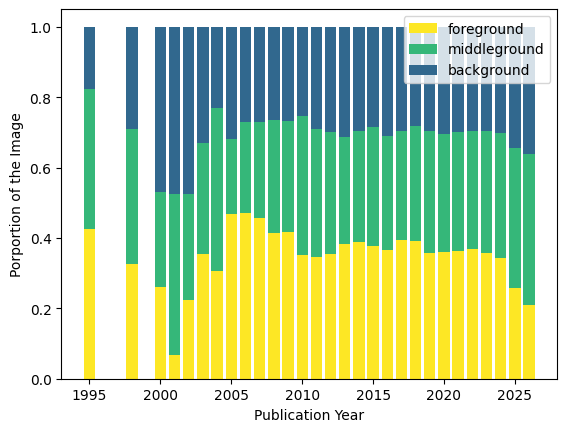

In [ ]:
fig, ax = plt.subplots()
book_years_axis = np.arange(2026-1995+1) + 1995
bottom = np.zeros(len(book_years_axis))

fmb_by_year_normalized = fmb_by_year / fmb_by_year.sum(axis=1, keepdims=True)

fmb_names = ["foreground", "middleground", "background"]

for i in range(fmb_by_year.shape[1]):
    ax.bar(
        book_years_axis,
        fmb_by_year_normalized[:, i],
        bottom=bottom,
        color=plt.cm.viridis(1-i/fmb_by_year.shape[1]),
        label=fmb_names[i]
    )
    bottom += fmb_by_year_normalized[:, i]

ax.set_xlabel("Publication Year")
ax.set_ylabel("Porportion of the Image")
_=ax.legend()

# Color

In [ ]:
def extract_dominant_color(image_array, n_colors=1):
    #image_array = (image_array if len(image_array.shape) == 3 else np.stack([image_array]*3, axis=-1))
    pixels = image_array.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_
    dominant_colors = np.round(dominant_colors).astype(int)
    return dominant_colors

dominant_colors = np.empty((df.shape[0], 3))

for i in tqdm(range(df.shape[0])):
  index = df['ID'].iloc[i]
  image_path = Path(IMAGE_PATH, f"{index}.png")
  image = Image.open(image_path)
  image = np.array(image)

  dominant_color = extract_dominant_color(image)[0]
  dominant_colors[index-1] = dominant_color

100%|██████████| 3898/3898 [52:05<00:00,  1.25it/s]


In [ ]:
np.save("/content/drive/MyDrive/dh/book_covers/dominant_colors.npy", dominant_colors)

In [ ]:
dominant_colors = np.load("/content/drive/MyDrive/dh/book_covers/dominant_colors.npy")
book_years = np.load("/content/drive/MyDrive/dh/book_covers/book_years.npy")
depth_by_height_list = np.load("/content/drive/MyDrive/dh/book_covers/depth_by_height_list.npy")
depth_by_width_list = np.load("/content/drive/MyDrive/dh/book_covers/depth_by_width_list.npy")

In [ ]:
palette = np.array([(255,255,0), (128,255,0), (0,255,0), (0,255,128),
           (0,255,255), (0,128,255), (0,0,255), (128,0,255),
           (255,0,255), (255,0,128), (255,0,0), (255,128,0),
           (255,255,255), (192,192,192), (128,128,128), (64,64,64), (0,0,0)])
palette_names = [
    "Yellow", "Yellow-Green", "Green", "Blue-Green", "Cyan Blue", "Blue", "Violet",
    "Red-Violet", "Magenta Red", "Red", "Orange", "Yellow-Orange", "White", "Light Gray",
    "Gray", "Dark Gray", "Black"
]


palette_lab = color.rgb2lab(palette / 255)
dominant_colors_lab = color.rgb2lab(dominant_colors / 255)

deltas = color.deltaE_ciede2000(
    dominant_colors_lab[:, np.newaxis, :],
    palette_lab[np.newaxis, :, :]
)
palette_ids = np.argmin(deltas, axis=1)

palette_by_year = np.zeros((2026 - 1995 + 1, len(palette)), dtype=np.uint32)
np.add.at(palette_by_year, (book_years.astype(np.uint32) - 1995, palette_ids), 1)

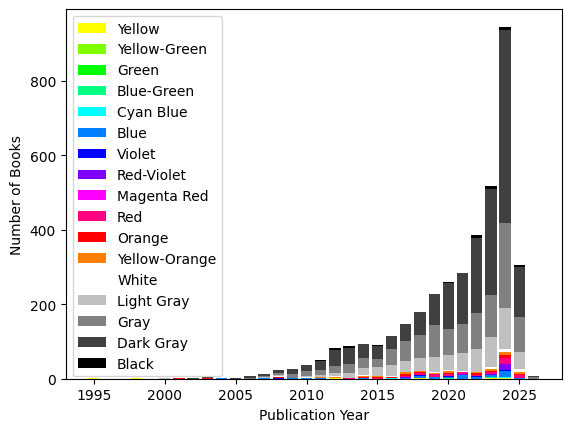

In [ ]:
fig, ax = plt.subplots()
book_years_axis = np.arange(2026-1995+1) + 1995
bottom = np.zeros(len(book_years_axis))

for i in range(palette_by_year.shape[1]):
    ax.bar(
        book_years_axis,
        palette_by_year[:, i],
        bottom=bottom,
        color=palette[i]/255,
        label=palette_names[i]
    )
    bottom += palette_by_year[:, i]

plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
_ = ax.legend()

<ipython-input-62-04c232f506d4>:5: RuntimeWarning: invalid value encountered in divide
  palette_by_year_normalized = palette_by_year / palette_by_year.sum(axis=1, keepdims=True)


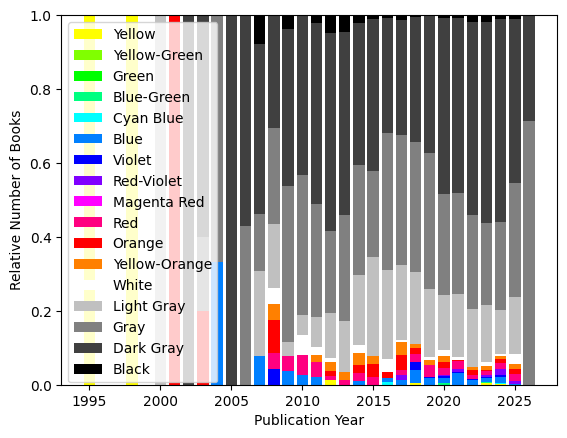

In [ ]:
fig, ax = plt.subplots()
book_years_axis = np.arange(2026-1995+1) + 1995
bottom = np.zeros(len(book_years_axis))

palette_by_year_normalized = palette_by_year / palette_by_year.sum(axis=1, keepdims=True)

for i in range(palette_by_year.shape[1]):
    ax.bar(
        book_years_axis,
        palette_by_year_normalized[:, i],
        bottom=bottom,
        color=palette[i]/255,
        label=palette_names[i]
    )
    bottom += palette_by_year_normalized[:, i]

plt.xlabel('Publication Year')
plt.ylabel('Relative Number of Books')
_ = ax.legend()

In [ ]:
np.save("/content/drive/MyDrive/dh/book_covers/color_by_height_list.npy", color_by_height_list)
np.save("/content/drive/MyDrive/dh/book_covers/color_by_width_list.npy", color_by_width_list)

In [ ]:
color_by_height_list = np.load("/content/drive/MyDrive/dh/book_covers/color_by_height_list.npy")
color_by_width_list = np.load("/content/drive/MyDrive/dh/book_covers/color_by_width_list.npy")

In [ ]:
saturation_by_height_list = np.divide(
    (np.max(color_by_width_list, axis=2) - np.min(color_by_width_list, axis=2)),
    np.max(color_by_width_list, axis=2),
    where=np.max(color_by_width_list, axis=2) != 0,
    out=np.zeros_like(np.max(color_by_width_list, axis=2))
)

saturation_by_width_list = np.divide(
    (np.max(color_by_height_list, axis=2) - np.min(color_by_height_list, axis=2)),
    np.max(color_by_height_list, axis=2),
    where=np.max(color_by_height_list, axis=2) != 0,
    out=np.zeros_like(np.max(color_by_height_list, axis=2))
)

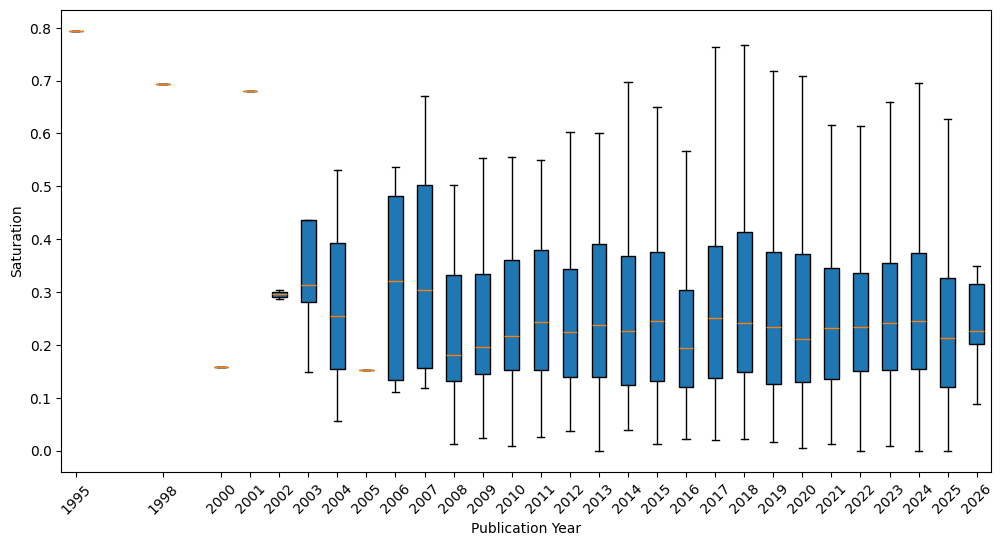

In [ ]:
mean_saturation = np.mean(saturation_by_height_list, axis=1)
unique_years = np.unique(book_years).astype(np.uint16)

grouped_data = [mean_saturation[book_years == year] for year in unique_years]

plt.figure(figsize=(12, 6))
plt.boxplot(grouped_data, positions=unique_years, patch_artist=True, showfliers=False)
plt.xticks(unique_years, rotation=45)
plt.xlabel('Publication Year')
plt.ylabel('Saturation')
plt.show()